In [112]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
# import os

import model_implementation_pipeline as m

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.express as px
# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
# from collections import Counter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>1. Getting data prepared for modelling</h1>

## 1.1 Loading Data

In [86]:
data  = pd.read_csv('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/preprocessed_data.csv', nrows=50000)
# data  = pd.read_csv('preprocessed_data.csv', nrows=50000) # you can take less number of rows like this
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [87]:
#Checking the columns and shape of the data
print('Column names: ', data.columns)
print('='*50)
print('Shape of the data (Rows, Columns): ', data.shape)
print('='*50)
print('Target Variable-> project_is_approved')

Column names:  Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')
Shape of the data (Rows, Columns):  (50000, 9)
Target Variable-> project_is_approved


In [88]:
# project_is_approved is target variable = y
y = data['project_is_approved'].values # Target Variable
X = data.drop(['project_is_approved'], axis=1) # Independent Variables
print(X.shape)
X.head(1)

(50000, 8)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [89]:
# train CV and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, stratify = y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size= 0.33, stratify = y_train)

print('Train Data Shape: ', X_train.shape)
print('CV Data Shape: ', X_cv.shape)
print('Test Data Shape: ', X_test.shape)

Train Data Shape:  (22445, 8)
CV Data Shape:  (11055, 8)
Test Data Shape:  (16500, 8)


[]

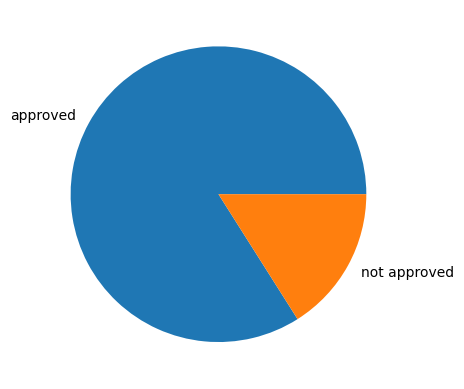

In [90]:
# checking the Data Skewness
y = [y_train.sum(), y_train.shape[0] - y_train.sum()]
plt.pie(y, labels= ['approved', 'not approved'])
plt.plot()

[]

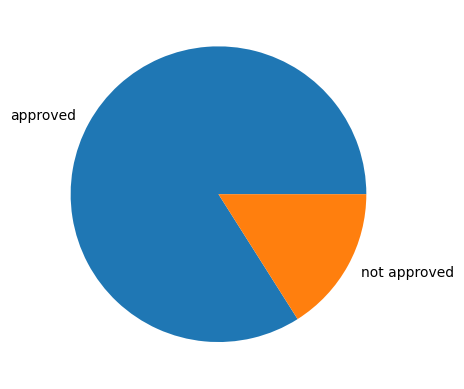

In [91]:
# checking the Data Skewness
y = [y_test.sum(), y_test.shape[0] - y_test.sum()]
plt.pie(y, labels= ['approved', 'not approved'])
plt.plot()

Note: As we have used stratify parameter this will distribute the class labels equally and removes skewness

<h2>1.3 Make Data Model Ready: encoding numerical and Categorical features</h2>

In [92]:
X.dtypes

school_state                                     object
teacher_prefix                                   object
project_grade_category                           object
teacher_number_of_previously_posted_projects      int64
clean_categories                                 object
clean_subcategories                              object
essay                                            object
price                                           float64
dtype: object

In [93]:
# Splitting data into categorical, numerical and descriptive categorial
numeric_data = (X.select_dtypes(include=[np.number])).columns
categorical_data = (X.select_dtypes(exclude=[np.number])).columns

In [94]:
vectorizer = CountVectorizer(min_df = 10, ngram_range=(1,4), max_features = 5000)
vectorizer.fit(X_train['essay'].values)

X_train_essay_bow= vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print(vectorizer.get_feature_names_out())
print("="*100)

After vectorizations
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)
['000' '10' '100' ... 'your generous' 'your generous donation' 'youth']


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 encoding categorical features: School State</h3>

In [95]:
# School state One Hot encoding

vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)  
print(vectorizer.get_feature_names_out())
print("="*100)

After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak' 'al' 'ar' 'az' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi' 'ia' 'id'
 'il' 'in' 'ks' 'ky' 'la' 'ma' 'md' 'me' 'mi' 'mn' 'mo' 'ms' 'mt' 'nc'
 'nd' 'ne' 'nh' 'nj' 'nm' 'nv' 'ny' 'oh' 'ok' 'or' 'pa' 'ri' 'sc' 'sd'
 'tn' 'tx' 'ut' 'va' 'vt' 'wa' 'wi' 'wv' 'wy']


<h3>1.4.2 encoding categorical features: teacher_prefix</h3>

In [96]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names_out())
print("="*100)

After vectorizations
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['dr' 'mr' 'mrs' 'ms' 'teacher']


<h3>1.4.3 encoding categorical features: project_grade_category</h3>

In [97]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names_out())
print("="*100)

After vectorizations
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['grades_3_5' 'grades_6_8' 'grades_9_12' 'grades_prek_2']


<h3>1.4.4 encoding numerical features: Price</h3>

In [98]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# the above class will take 2D array as input
scaler.fit(X_train[['price']])

X_train_price_sd= scaler.transform(X_train[['price']])
X_cv_price_sd = scaler.transform(X_cv[['price']])
X_test_price_sd = scaler.transform(X_test[['price']])

print("After Standardization")
print(X_train_price_sd.shape, y_train.shape)
print(X_cv_price_sd.shape, y_cv.shape)
print(X_test_price_sd.shape, y_test.shape)
print("="*100)


After Standardization
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


<h3>1.4.5 encoding categorical descriptive feature: essay</h3>

In [99]:
# using a pre-trained model (Glove) to find the AvgW2V for essay feature
with open('/Users/shubhamshivendra/workspace/Project/Donors Choose/Data Sets/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    # storing the words in the variable
    glove_words = set(model.keys())
    print('Total words present in Glove:', len(glove_words))
    # Each word is trained on 300D 
    print('# of Dimensions: ',len(model[list(glove_words)[0]]))

Total words present in Glove: 51510
# of Dimensions:  300


In [100]:
# Average Word2Vec for Train data

avg_w2v_vectors_train  = []
for sentence in tqdm(X_train['essay'].values):
    vector = np.zeros(300) # as the model is trained on 300D we need to initialize each word in sentence with 300D
    cnt_words = 0
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)
 
print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████| 22445/22445 [00:03<00:00, 6789.38it/s]


22445
300


In [18]:
# Average Word2Vec for CV data

avg_w2v_vectors_cv  = []
for sentence in tqdm(X_cv['essay'].values):
    vector = np.zeros(300) # as the model is trained on 300D we need to initialize each word in sentence with 300D
    cnt_words = 0
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)
 
print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|██████████| 11055/11055 [00:01<00:00, 7378.15it/s]

11055
300


In [101]:
# Average Word2Vec for test data

avg_w2v_vectors_test  = []
for sentence in tqdm(X_test['essay'].values):
    vector = np.zeros(300) # as the model is trained on 300D we need to initialize each word in sentence with 300D
    cnt_words = 0
    for word in sentence.split():
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)
 
print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████| 16500/16500 [00:02<00:00, 7262.10it/s]

16500
300



### 1.4.5 Concatinating all the features

In [102]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr = hstack((avg_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_sd)).tocsr()
X_cr = hstack((avg_w2v_vectors_cv, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_sd)).tocsr()
X_te = hstack((avg_w2v_vectors_test, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_sd)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 361) (22445,)
(11055, 361) (11055,)
(16500, 361) (16500,)


<h2>1.5 Appling KNN on different kind of featurization</h2>

#### 1.5.1 KNN Hyper parameter Tuning

##### 1.5.1.1 Method 1: Simple for loop (Will act as GridSearchCV without cross validation)

In [104]:
# this function will take parameter estimator and data and will yield probability score in batches
def batch_pred(clf, data):
    y_data_pred = []
    data_loop = data.shape[0] - data.shape[0] % 1000
    for i in range(0, data_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[data_loop:])[:,1])
    return y_data_pred

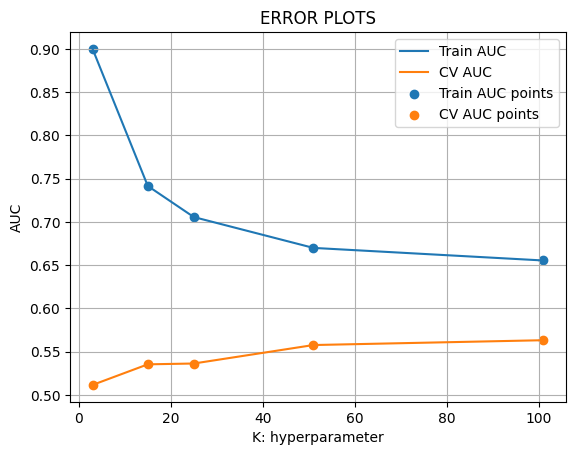

In [105]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
# set of parameters to find the bese nearest neighbors
k = [3, 15, 25, 51, 101]
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_tr, y_train)
    X_train_proba = batch_pred(knn, X_tr)
    X_cv_proba = batch_pred(knn, X_cr)
    train_auc.append(roc_auc_score(y_train, X_train_proba))
    cv_auc.append(roc_auc_score(y_cv, X_cv_proba))
plt.plot(k, train_auc, label = 'Train AUC')
plt.plot(k, cv_auc, label = 'CV AUC')

plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

##### 1.5.1.2 Method 2: Implementing Randomized Search CV with Cross Folds = 3


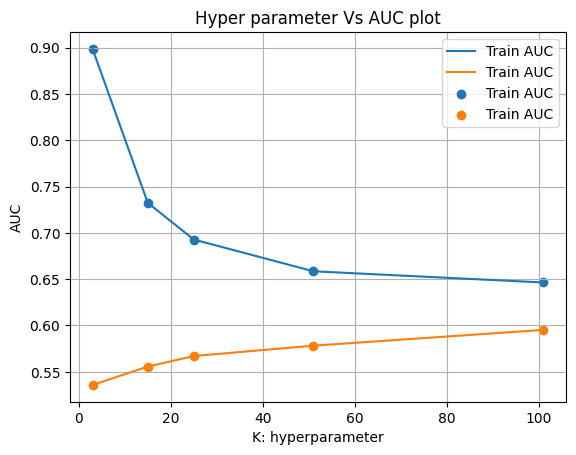

In [97]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

neigh = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors': [3, 15, 25, 51, 101]}
clf = RandomizedSearchCV(neigh, parameters, cv = 3, scoring= 'roc_auc', return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])
results.head()

train_auc = results['mean_train_score']
cv_auc = results['mean_test_score']
k = results['param_n_neighbors']

plt.plot(k, train_auc, label = 'Train AUC')
plt.plot(k, cv_auc, label = 'Train AUC')

plt.scatter(k, train_auc, label = 'Train AUC')
plt.scatter(k, cv_auc, label = 'Train AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#### 1.5.1.3 Testing the performance of the model on test data, plotting ROC Curves

In [107]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_k = 95

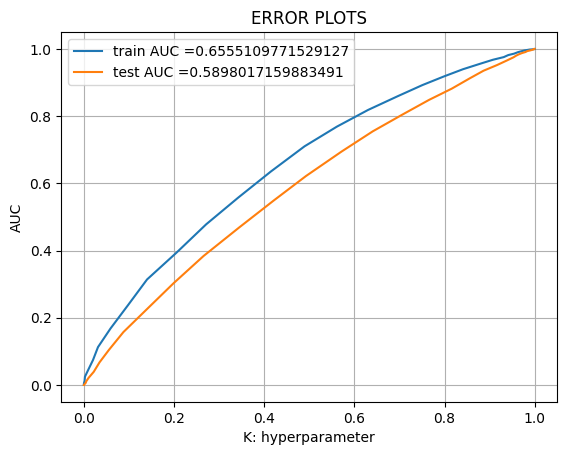

In [108]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_pred(neigh, X_tr)    
y_test_pred = batch_pred(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [109]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [110]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
cm_train_KNN = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
cm_test_KNN = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.3716771968140247 for threshold 0.842
Train confusion matrix
[[ 2104  1491]
 [ 6879 11971]]
Test confusion matrix
[[1340 1302]
 [5241 8617]]


<h2>1.6 Appling Logistic Regression on different kind of featurization</h2>

#### 1.6.1 Logistic Regression Hyper parameter Tuning

##### 1.6.1.1 Method 1: Simple for loop (Will act as GridSearchCV without cross validation)

100%|██████████| 5/5 [00:08<00:00,  1.78s/it]


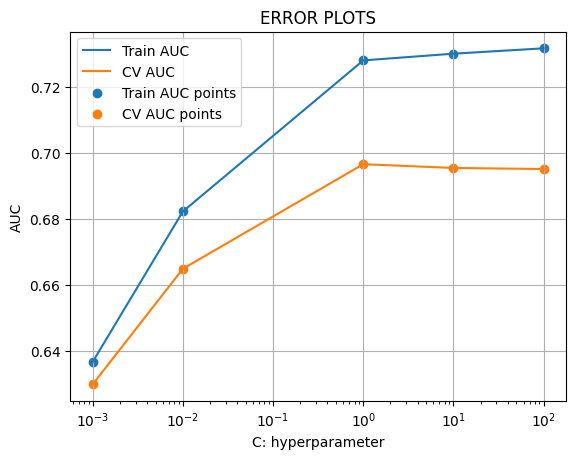

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
parameters = {'C' : [0.001, 0.01, 1.0, 10.0, 100.0]}
for i in tqdm(parameters['C']):
    clf = LogisticRegression(C = i)
    clf.fit(X_tr, y_train)
    train_auc.append(roc_auc_score(y_train, batch_pred(clf, X_tr)))
    cv_auc.append(roc_auc_score(y_cv, batch_pred(clf, X_cr)))

plt.plot(parameters['C'], train_auc, label='Train AUC')
plt.plot(parameters['C'], cv_auc, label='CV AUC')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.xscale("log")
plt.grid()
plt.show()



##### 1.6.1.2 Method 2: Implementing Randomized Search CV with Cross Folds = 3


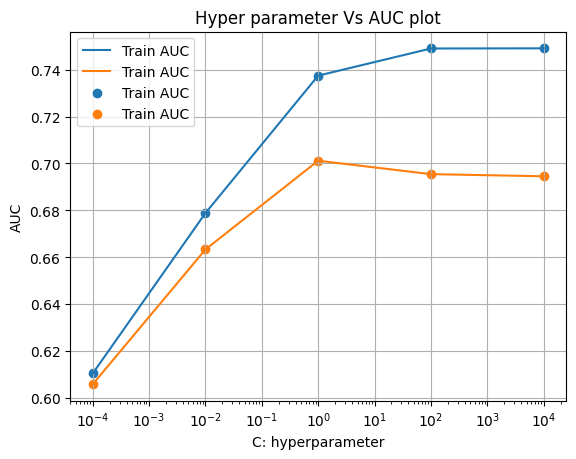

In [110]:
parameters = {'C' : [0.0001, 0.01, 1.0, 100.0, 10000.0]}

log = LogisticRegression(max_iter= 1000)
tuning = RandomizedSearchCV(log, param_distributions= parameters, scoring= 'roc_auc', cv= 3, n_jobs=-1, return_train_score= True)

tuning.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(tuning.cv_results_)

results = results.sort_values(['param_C'])
results.head()

train_auc = results['mean_train_score']
cv_auc = results['mean_test_score']
k = results['param_C']

plt.plot(k, train_auc, label = 'Train AUC')
plt.plot(k, cv_auc, label = 'Train AUC')

plt.scatter(k, train_auc, label = 'Train AUC')
plt.scatter(k, cv_auc, label = 'Train AUC')

plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.xscale('log')
plt.grid()
plt.show()

#### 1.6.1.3 Testing the performance of the model on test data, plotting ROC Curves

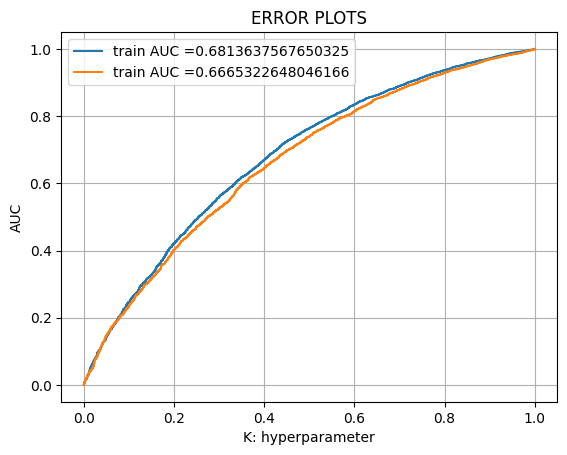

In [113]:
# From the above two plots we can see that the best parameter is 0.01
best_param = 0.01

# Training the model with the best param
log = LogisticRegression(C = best_param, max_iter= 1000, n_jobs = -1)
log.fit(X_tr, y_train)

y_train_pred = batch_pred(log, X_tr)
y_test_pred = batch_pred(log, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


In [114]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [115]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
cm_train_log = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
cm_test_log = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.4030722894677621 for threshold 0.832
Train confusion matrix
[[ 2112  1483]
 [ 5917 12933]]
Test confusion matrix
[[1488 1154]
 [4368 9490]]


<h2>1.7 Implementing Decision Tree:</h2>

In [21]:
# 9. Perform hyperparameter tuning and plot either heatmap or 3d plot.
estimator = DecisionTreeClassifier(random_state=0)
param = {'max_depth': [3, 15, 25, 51, 101],
         'min_samples_split': [5, 10, 100, 500]}

clf = RandomizedSearchCV(estimator, param_distributions = param, cv = 3, scoring= 'roc_auc', return_train_score=True)
clf.fit(X_tr, y_train)

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=0),
                   param_distributions={'max_depth': [3, 15, 25, 51, 101],
                                        'min_samples_split': [5, 10, 100, 500]},
                   return_train_score=True, scoring='roc_auc')

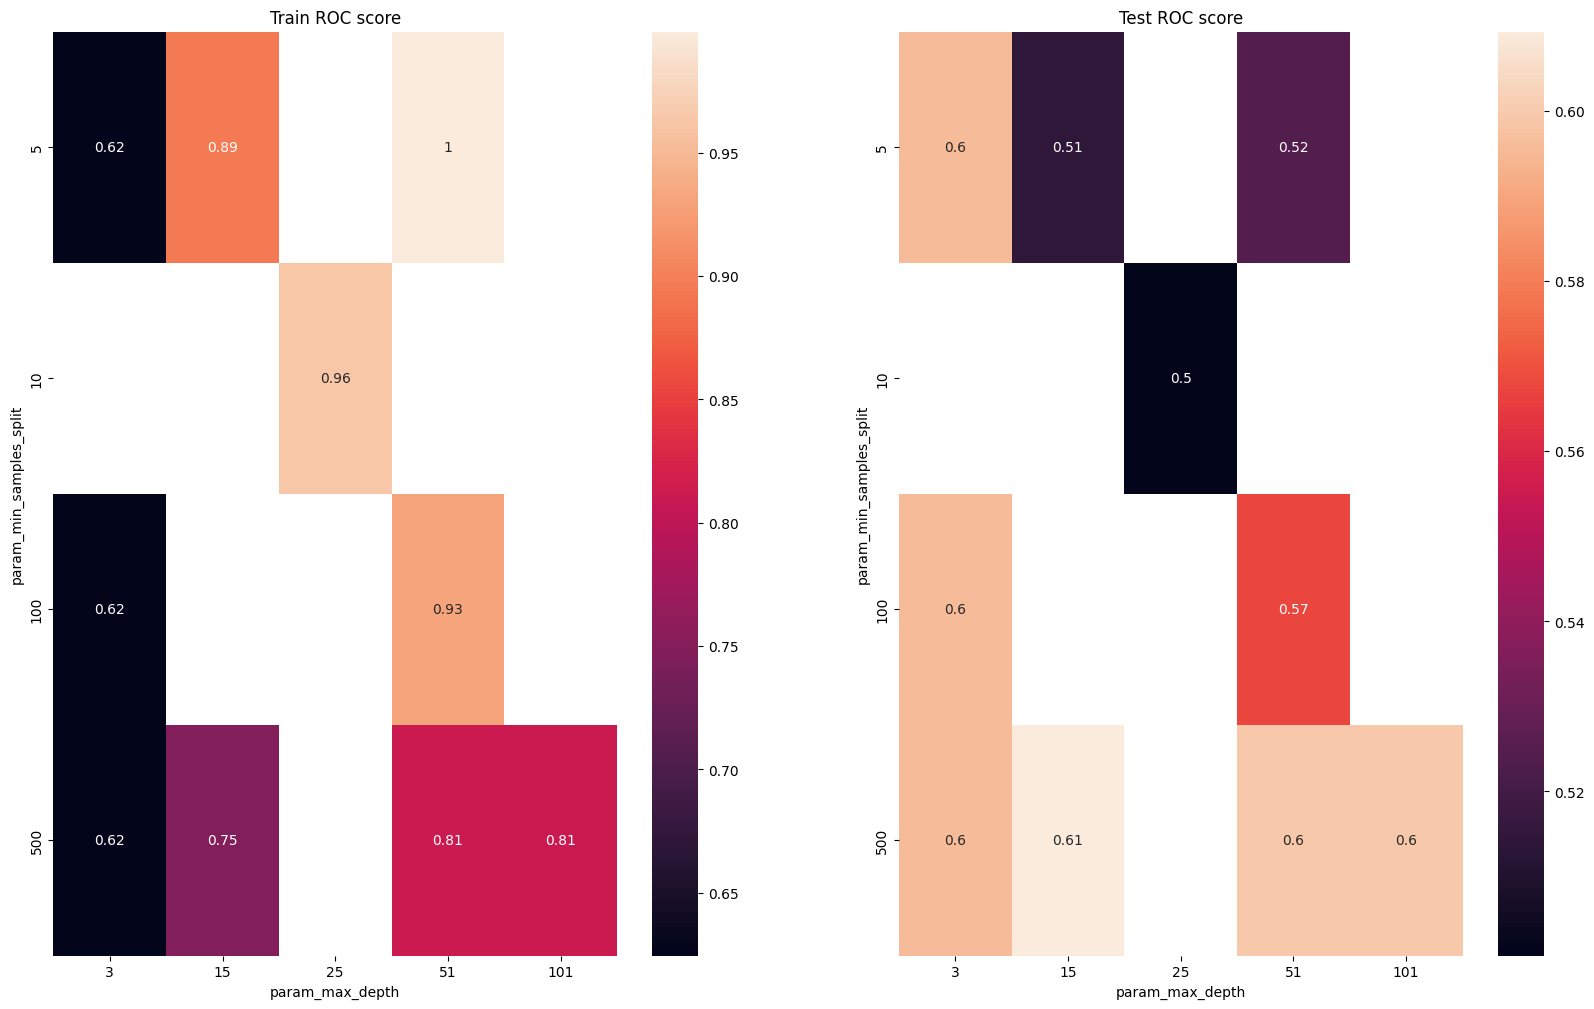

In [116]:
# Plotting Heat map to see the best hyper parameter both in Train and Test data
results = pd.DataFrame.from_dict(clf.cv_results_)
pivot_train = results.pivot(index = 'param_min_samples_split', columns = 'param_max_depth', values = 'mean_train_score')
pivot_test = results.pivot(index = 'param_min_samples_split', columns = 'param_max_depth', values = 'mean_test_score')
# Plotting heatmap-
fig, ax = plt.subplots(1,2, figsize=(20,12))
sns.heatmap(pivot_train, annot = True, ax = ax[0])
ax[0].title.set_text('Train ROC score')
sns.heatmap(pivot_test, annot = True, ax = ax[1])
ax[1].title.set_text('Test ROC score')

Model trained1


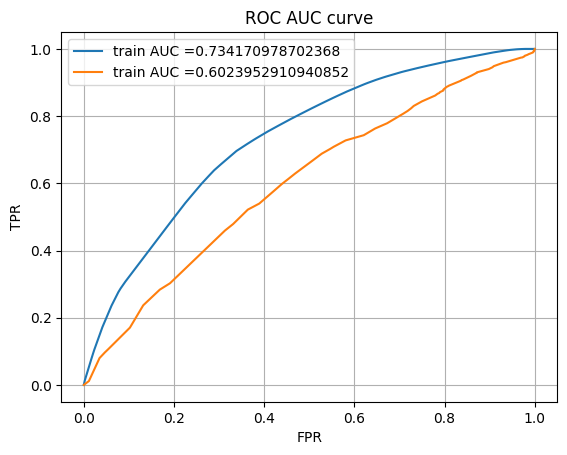

In [117]:
# Training the mode with the best parameter
clf.best_params_ # It looks like best parameter is {'min_samples_split': 500, 'max_depth': 15} but we will keep {'min_samples_split': 5, 'max_depth': 15}
est = DecisionTreeClassifier(random_state=0, max_depth= 15, min_samples_split= 500)
est.fit(X_tr, y_train)
print('Model trained1')

y_train_pred = batch_pred(est, X_tr)
y_test_pred = batch_pred(est, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC AUC curve")
plt.grid()
plt.show()


In [118]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
cm_train_dt = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
cm_test_dt = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.4605755857494383 for threshold 0.858
Train confusion matrix
[[ 2378  1217]
 [ 5725 13125]]
Test confusion matrix
[[1304 1338]
 [4617 9241]]


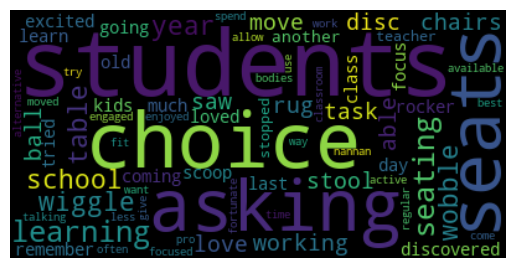

In [84]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(X_test[X_test.index.isin(k)].essay.values[0])

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<h2>1.7 Comparing both the models using confusion metrics:</h2>

In [119]:
print(cm_train_log) # Logistic regression training confusion matrix
print(cm_test_log) # Logistic regression test confusion matrix
print(cm_train_KNN) # KNN training confusion matrix
print(cm_test_KNN) # KNN test confusion matrix
print("="*50)
conf_matrix = {'LogisticRegression Train Confusion Matrix': cm_train_log,
               'LogisticRegression Test Confusion Matrix': cm_test_log,
               'KNN Train Confusion Matrix': cm_train_KNN,
               'KNN Test Confusion Matrix': cm_test_KNN,
               'Decision Tree train Confusion Matrix' : cm_train_dt,
               'Decision Tree test Confusion Matrix' : cm_test_dt
               }
print(conf_matrix)

[[ 2112  1483]
 [ 5917 12933]]
[[1488 1154]
 [4368 9490]]
[[ 2104  1491]
 [ 6879 11971]]
[[1340 1302]
 [5241 8617]]
{'LogisticRegression Train Confusion Matrix': array([[ 2112,  1483],
       [ 5917, 12933]]), 'LogisticRegression Test Confusion Matrix': array([[1488, 1154],
       [4368, 9490]]), 'KNN Train Confusion Matrix': array([[ 2104,  1491],
       [ 6879, 11971]]), 'KNN Test Confusion Matrix': array([[1340, 1302],
       [5241, 8617]]), 'Decision Tree train Confusion Matrix': array([[ 2378,  1217],
       [ 5725, 13125]]), 'Decision Tree test Confusion Matrix': array([[1304, 1338],
       [4617, 9241]])}


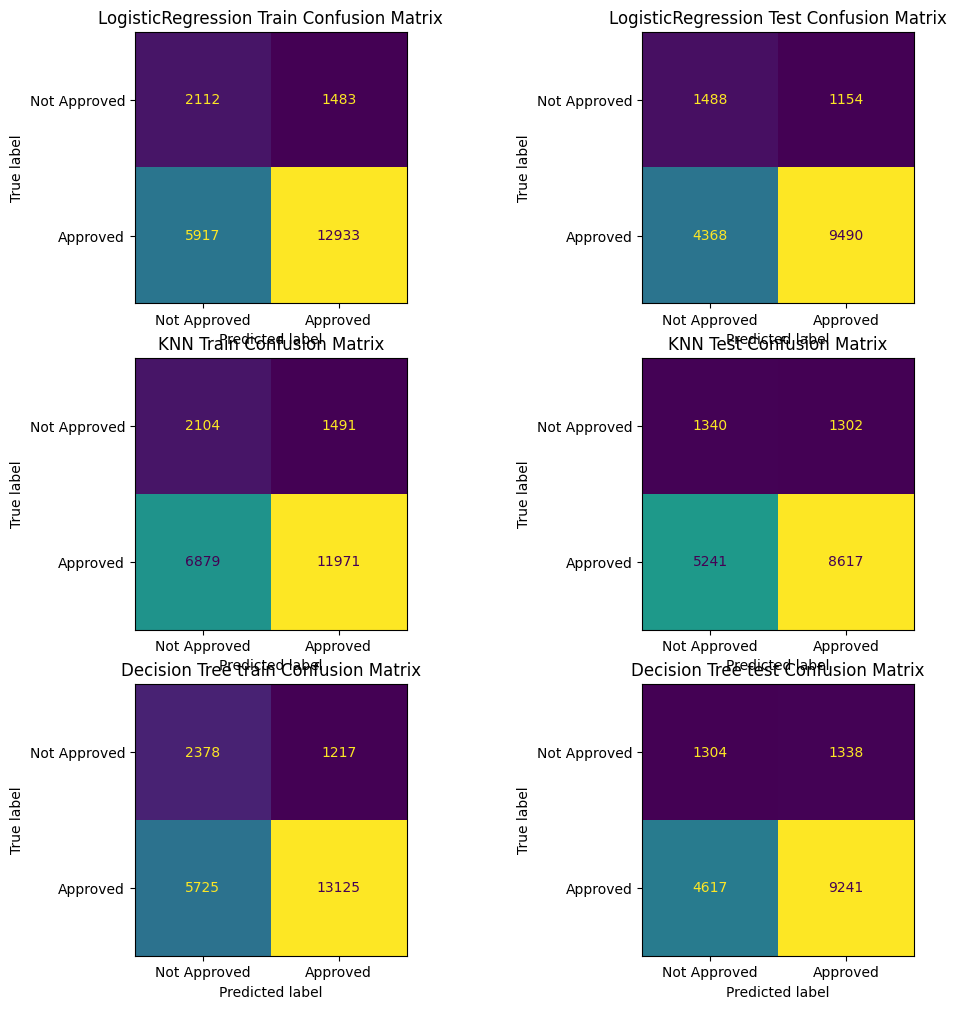

In [124]:
conf_mat_list = conf_matrix.keys()
fig, ax = plt.subplots(3,2, figsize=(12,12))
row = 0
col = 0
for j, i in enumerate(conf_mat_list):
    if j == 2:
      row = 1
      col = 0
    elif j == 4:
       row = 2
       col = 0
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix[i], display_labels = ['Not Approved', 'Approved'])
    cm_display.plot(ax=ax[row,col], colorbar=False)
    ax[row,col].title.set_text(f'{i}')
    col+=1